In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import json
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.express as px
from shapely.geometry import mapping, shape

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
# reading bikeshare data
tq1=pd.read_csv("../input/bikeshare-ridership-2018/Bike Share Toronto Ridership_Q1 2018.csv",header=0)
tq2=pd.read_csv("../input/bikeshare-ridership-2018/Bike Share Toronto Ridership_Q2 2018.csv",header=0)
tq3=pd.read_csv("../input/bikeshare-ridership-2018/Bike Share Toronto Ridership_Q3 2018.csv",header=0)
tq4=pd.read_csv("../input/bikeshare-ridership-2018/Bike Share Toronto Ridership_Q4 2018.csv",header=0)

combined_list=[tq1,tq2,tq3,tq4]
toronto_bike_share=pd.concat(combined_list)
toronto_bike_share.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922955 entries, 0 to 363489
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   trip_id                int64 
 1   trip_duration_seconds  int64 
 2   from_station_id        int64 
 3   trip_start_time        object
 4   from_station_name      object
 5   trip_stop_time         object
 6   to_station_id          int64 
 7   to_station_name        object
 8   user_type              object
dtypes: int64(4), object(5)
memory usage: 146.7+ MB


In [87]:
#reading bike theft data
bike_theft=pd.read_csv("../input/bicycle-theft/Bicycle_Thefts_Toronto.csv")
Toronto_data=bike_theft[['Index_', 'event_unique_id', 'Primary_Offence',
       'Occurrence_Date', 'Occurrence_Year', 'Occurrence_Month',
       'Occurrence_Day', 'Occurrence_Time', 'Division', 'City',
       'Location_Type', 'Premise_Type', 'Bike_Make', 'Bike_Model', 'Bike_Type',
       'Bike_Speed', 'Bike_Colour', 'Cost_of_Bike', 'Status', 'Hood_ID',
       'Neighbourhood', 'Lat', 'Long']].copy()
Toronto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21584 entries, 0 to 21583
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Index_            21584 non-null  int64  
 1   event_unique_id   21584 non-null  object 
 2   Primary_Offence   21584 non-null  object 
 3   Occurrence_Date   21584 non-null  object 
 4   Occurrence_Year   21584 non-null  int64  
 5   Occurrence_Month  21584 non-null  int64  
 6   Occurrence_Day    21584 non-null  int64  
 7   Occurrence_Time   21584 non-null  object 
 8   Division          21584 non-null  int64  
 9   City              21584 non-null  object 
 10  Location_Type     21584 non-null  object 
 11  Premise_Type      21584 non-null  object 
 12  Bike_Make         21584 non-null  object 
 13  Bike_Model        13443 non-null  object 
 14  Bike_Type         21584 non-null  object 
 15  Bike_Speed        21584 non-null  int64  
 16  Bike_Colour       19855 non-null  object

In [18]:
#reading station
station_info=pd.read_json('../input/station-names/station_information')
stations = station_info['data']['stations']
stations = pd.DataFrame(stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  627 non-null    float64
 1   name        627 non-null    object 
 2   lat         627 non-null    float64
 3   lon         627 non-null    float64
dtypes: float64(3), object(1)
memory usage: 19.7+ KB


In [69]:
# toronto_bike_share = pd.DataFrame({"time_start":range(1, 25)})

b = ['00:00:00','08:00:00','12:00:00','16:00:00','20:00:00']
b=pd.to_datetime(b,format='%H:%M:%S')
l = ['Morning','Noon','Eve','Night']
toronto_bike_share["time_of_day_start"] = pd.cut(toronto_bike_share["time_start"], bins=b, labels=l, include_lowest=True)
toronto_bike_share["time_of_day_stop"] = pd.cut(toronto_bike_share["time_stop"], bins=b, labels=l, include_lowest=True)

toronto_bike_share.drop(["trip_start_time"], axis=1,inplace=True)
toronto_bike_share.drop(["trip_stop_time"], axis=1,inplace=True)
toronto_bike_share.head()


,trip_id,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,month_start,weekday_start,time_start,month_stop,weekday_stop,time_stop,session,time_of_day_start,time_of_day_stop
0,2383648,393,7018,Bremner Blvd / Rees St,7176,Bathurst St / Fort York Blvd,Annual Member,January,Monday,1900-01-01 00:47:00,January,Monday,1900-01-01 00:54:00,Morning,Morning,Morning
1,2383649,625,7184,Ossington Ave / College St,7191,Central Tech (Harbord St),Annual Member,January,Monday,1900-01-01 00:52:00,January,Monday,1900-01-01 01:03:00,Morning,Morning,Morning
2,2383650,233,7235,Bay St / College St (West Side) - SMART,7021,Bay St / Albert St,Annual Member,January,Monday,1900-01-01 00:55:00,January,Monday,1900-01-01 00:59:00,Morning,Morning,Morning
3,2383651,1138,7202,Queen St W / York St (City Hall),7020,Phoebe St / Spadina Ave,Annual Member,January,Monday,1900-01-01 00:57:00,January,Monday,1900-01-01 01:16:00,Morning,Morning,Morning
4,2383652,703,7004,University Ave / Elm St,7060,Princess St / Adelaide St E,Annual Member,January,Monday,1900-01-01 01:00:00,January,Monday,1900-01-01 01:12:00,Morning,Morning,Morning


In [70]:
toronto_bike_share.loc[toronto_bike_share['to_station_id']==7068,'to_station_id']=7399
toronto_bike_share.loc[toronto_bike_share['to_station_id']==7219,'to_station_id']=7148
toronto_bike_share.loc[toronto_bike_share['from_station_id']==7068,'from_station_id']=7399
toronto_bike_share.loc[toronto_bike_share['from_station_id']==7219,'from_station_id']=7148



toronto_bike_share.head()

,trip_id,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type,month_start,weekday_start,time_start,month_stop,weekday_stop,time_stop,session,time_of_day_start,time_of_day_stop
0,2383648,393,7018,Bremner Blvd / Rees St,7176,Bathurst St / Fort York Blvd,Annual Member,January,Monday,1900-01-01 00:47:00,January,Monday,1900-01-01 00:54:00,Morning,Morning,Morning
1,2383649,625,7184,Ossington Ave / College St,7191,Central Tech (Harbord St),Annual Member,January,Monday,1900-01-01 00:52:00,January,Monday,1900-01-01 01:03:00,Morning,Morning,Morning
2,2383650,233,7235,Bay St / College St (West Side) - SMART,7021,Bay St / Albert St,Annual Member,January,Monday,1900-01-01 00:55:00,January,Monday,1900-01-01 00:59:00,Morning,Morning,Morning
3,2383651,1138,7202,Queen St W / York St (City Hall),7020,Phoebe St / Spadina Ave,Annual Member,January,Monday,1900-01-01 00:57:00,January,Monday,1900-01-01 01:16:00,Morning,Morning,Morning
4,2383652,703,7004,University Ave / Elm St,7060,Princess St / Adelaide St E,Annual Member,January,Monday,1900-01-01 01:00:00,January,Monday,1900-01-01 01:12:00,Morning,Morning,Morning


Text(0.5, 1.0, 'Membership Type 2018')

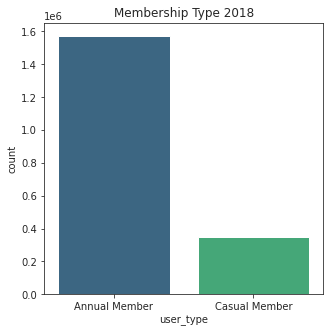

In [71]:
plt.figure(figsize=(5,5))
sns.set_style('ticks')
sns.countplot(x='user_type',data=toronto_bike_share,palette='viridis')
plt.title('Membership Type 2018')

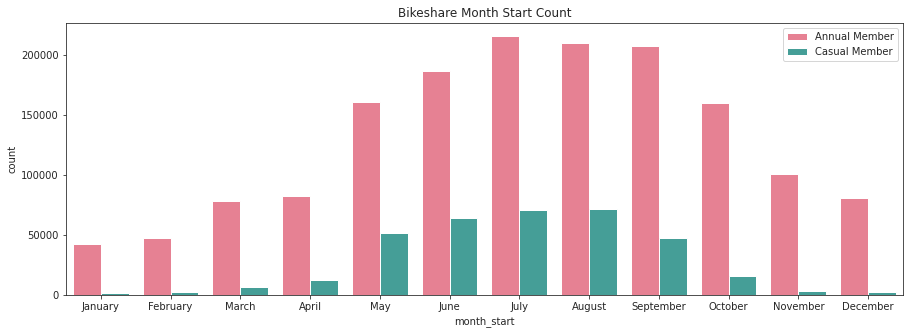

In [72]:
plt.figure(figsize=(15,5))
sns.set_style('ticks')
ridership = sns.countplot(data=toronto_bike_share, x='month_start', hue='user_type', palette='husl')
plt.title('Bikeshare Month Start Count')
plt.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.5)

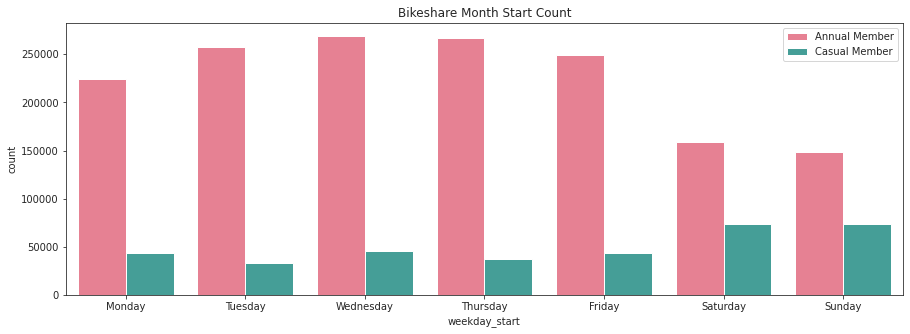

In [73]:
plt.figure(figsize=(15,5))
sns.set_style('ticks')
ridership = sns.countplot(data=toronto_bike_share, x='weekday_start', hue='user_type', palette='husl')
plt.title('Bikeshare Month Start Count')
plt.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.5)

Text(0.5, 1.0, 'Top 5 Departing Stations:Annual Members')

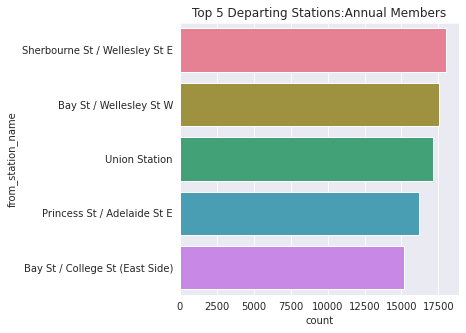

In [74]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.countplot(y=toronto_bike_share[toronto_bike_share['user_type']=='Annual Member']['from_station_name'],data=toronto_bike_share, palette='husl', order=toronto_bike_share[toronto_bike_share['user_type']=='Annual Member']['from_station_name'].value_counts().index[:5])
plt.title('Top 5 Departing Stations:Annual Members')

Text(0.5, 1.0, 'Top 5 Arriving Stations:Casual Members')

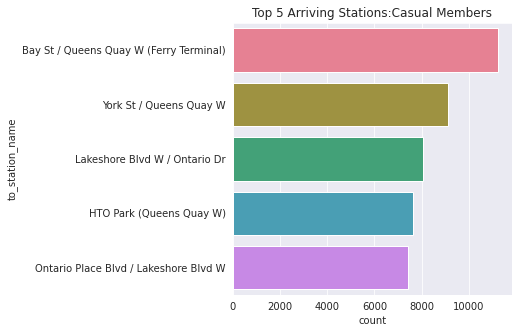

In [75]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.countplot(y=toronto_bike_share[toronto_bike_share['user_type']=='Casual Member']['to_station_name'],data=toronto_bike_share, palette='husl', order=toronto_bike_share[toronto_bike_share['user_type']=='Casual Member']['to_station_name'].value_counts().index[:5])
plt.title('Top 5 Arriving Stations:Casual Members')

Text(0.5, 1.0, 'Top 5 Departing Stations:Casual Members')

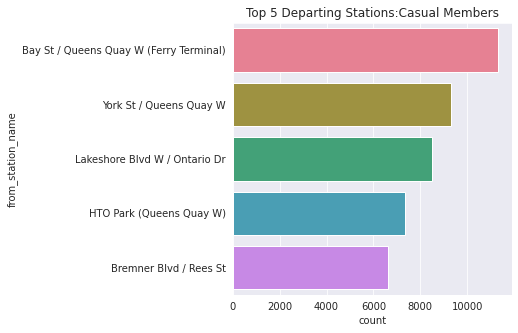

In [76]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.countplot(y=toronto_bike_share[toronto_bike_share['user_type']=='Casual Member']['from_station_name'],data=toronto_bike_share, palette='husl', order=toronto_bike_share[toronto_bike_share['user_type']=='Casual Member']['from_station_name'].value_counts().index[:5])
plt.title('Top 5 Departing Stations:Casual Members')

Text(0.5, 1.0, 'Top 5 Arriving Stations:Annual Members')

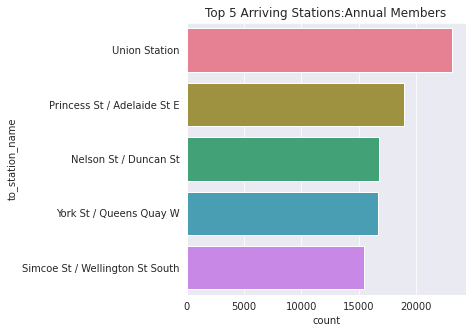

In [77]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.countplot(y=toronto_bike_share[toronto_bike_share['user_type']=='Annual Member']['to_station_name'],data=toronto_bike_share, palette='husl', order=toronto_bike_share[toronto_bike_share['user_type']=='Annual Member']['to_station_name'].value_counts().index[:5])
plt.title('Top 5 Arriving Stations:Annual Members')

Text(0.5, 1.0, 'Membership Type 2018')

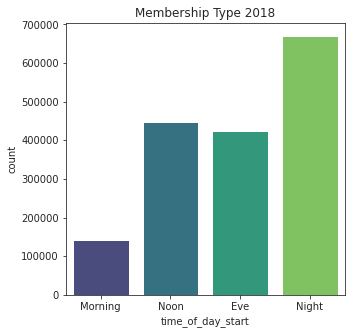

In [81]:
plt.figure(figsize=(5,5))
sns.set_style('ticks')
sns.countplot(x='time_of_day_start',data=toronto_bike_share,palette='viridis')
plt.title('Time of the day to start')

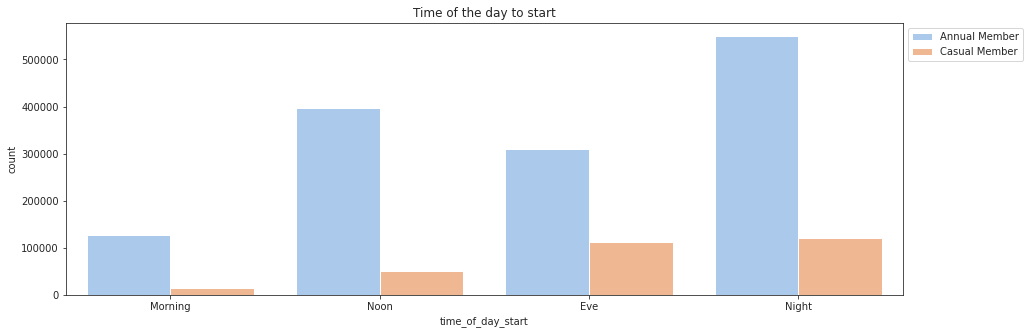

In [84]:
plt.figure(figsize=(15,5))
sns.set_style('ticks')
ridership = sns.countplot(data=toronto_bike_share, x='time_of_day_start', hue='user_type', palette='pastel')
plt.title('Time of the day to start')
plt.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.5)

<AxesSubplot:xlabel='time_of_day_start', ylabel='weekday_start'>

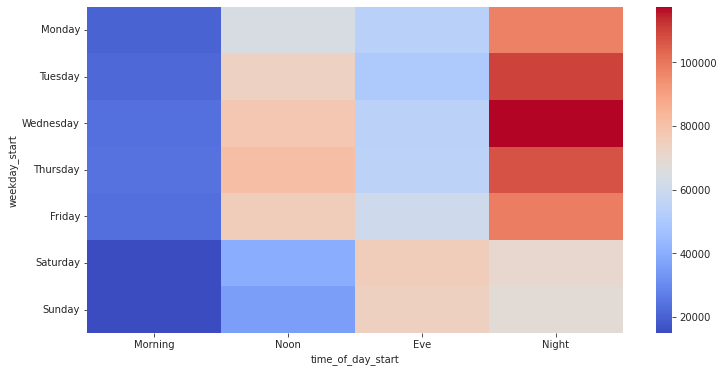

In [95]:
daily_activity = toronto_bike_share.groupby(by=['weekday_start','time_of_day_start']).count()['user_type'].unstack()
daily_activity.head()
plt.figure(figsize=(12,6))
sns.heatmap(daily_activity,cmap='coolwarm')

Text(0.5, 1.0, 'Top 5 Bike Theft location type')

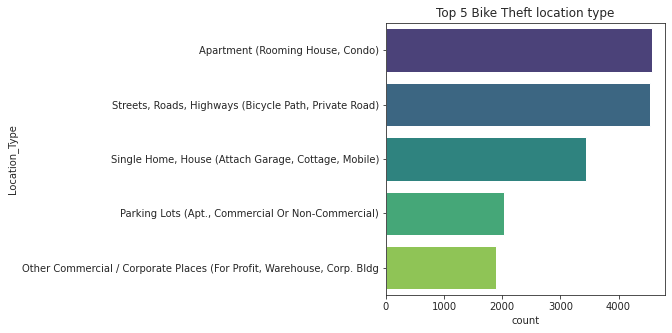

In [97]:
plt.figure(figsize=(5,5))
sns.set_style('ticks')
sns.countplot(y='Location_Type',data=Toronto_data,palette='viridis',order=pd.value_counts(Toronto_data['Location_Type']).iloc[:5].index)
plt.title('Top 5 Bike Theft location type')

In [16]:
#map parking, station and theft 


# df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)

# geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
# gdf = GeoDataFrame(stations, geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

fig_px = px.scatter_mapbox(stations, lat="lat", lon="lon",
                           hover_name="name",
                           zoom=11, height=300)
fig_px.update_layout(mapbox_style="open-street-map",
                     margin={"r":0,"t":0,"l":0,"b":0})

fig_px.show()

<AxesSubplot:>

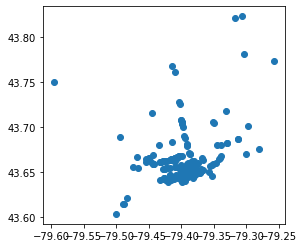

In [57]:

parkings=gpd.read_file("../input/bike-geojson/Bicycle Parking Racks Data.geojson")

parkings.plot()

# iska mujhe aa nahi raha


<AxesSubplot:>

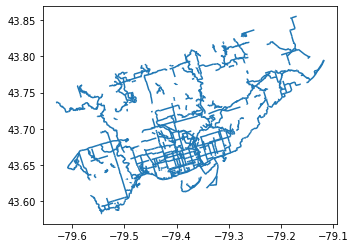

In [58]:
bikeway=gpd.read_file("../input/bike-geojson/Bike network data (1).geojson")
bikeway.plot()
